# Homework 3

This skeleton of a notebook should get you started on the first part, in which you will have to mask data and handle outliers.  I have included code to make a plot to visualize the data.

## Part 1 : Outlier treatment and Bootstrapping

In [1]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize
import emcee
import corner
from tqdm import tqdm

plt.style.use('phys240.mplstyle')

This plot shows real data from the *Gaia* satellite.  There are a number of fields in this table, which you can access as shown.  I have printed out the names below the short block of code.  You'll use a few of these; I define them below:

`pmra`: motion across the sky (think $x$ direction), measured in angular units per time.  For example, a star moving at 1 milliarcsecond per year (funny astronomer units) would take 3.6 million years to travel one degree across the sky.

`pmdec`: same as `pmra`, but in the $y$ direction

`ra`, `dec`: position in the sky (don't worry too much about these)

`parallax`: position shift due to the changing perspective of the Earth through the year.  As the Earth moves around the Sun, the apparent positions of the stars change relative to a background very far away.  The distance is related to parallax by 

${\rm distance~in~parsecs} = 1000/{\rm parallax~in~milliarcseconds}$

The parallaxes here are given in units of milliarcseconds.  A parsec (another astronomer unit) is about 3.26 light years, or $3.0857 \times 10^{18}\,$cm (astronomers also like cgs).

`radial_velocity`: velocity of the star towards us (if negative) or away from us (if positive), measured in km/s.

The data set provided has a few thousand stars in a cluster, and a bunch more stars scattered through space that happen to be near the cluster in projection.  Your tasks will be to estimate which stars are members of the cluster, to estimate the cluster's proper motion, distance from Earth, and internal motion, and to put error bars on these estimates.  You can see the cluster in the figure: it's the patch of dark blue points (parallaxes around 2.5 milliarcseconds) at proper motions of around $-$5 in $x$ and +12 in $y$--a patch in velocity space as represented here.

['source_id', 'ra', 'ra_error', 'dec', 'dec_error', 'parallax', 'parallax_error', 'pmra', 'pmra_error', 'pmdec', 'pmdec_error', 'radial_velocity', 'radial_velocity_error']


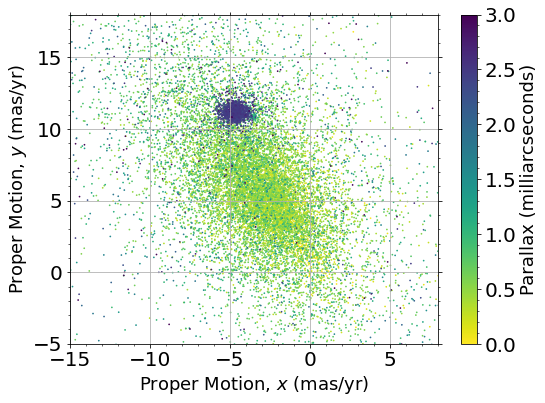

In [2]:
t = fits.open('NGC2516_Gaia.fits.gz')[1].data
print(t.names)
plt.figure(figsize=(8, 6))
plt.scatter(t['pmra'], t['pmdec'], c=t['parallax'], s=0.5, cmap="viridis_r", vmin=0, vmax=3)
plt.xlim(-15, 8)
plt.ylim(-5, 18)
plt.colorbar(label="Parallax (milliarcseconds)")
plt.xlabel(r"Proper Motion, $x$ (mas/yr)")
plt.ylabel(r"Proper Motion, $y$ (mas/yr)")
plt.tight_layout()
plt.savefig("NGC2516_figure.pdf")

### a.)

Plotting the parallaxes of all stars (parallax $\sim$ 1/distance).

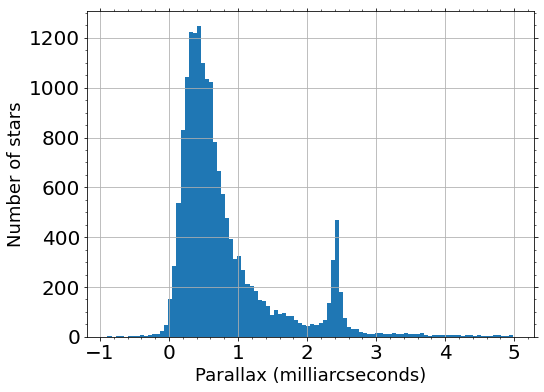

In [3]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.hist(t['parallax'], bins=100)
ax.set_xlabel('Parallax (milliarcseconds)')
ax.set_ylabel('Number of stars')
plt.show()

### b.)

We assume that for all starts in the cluster there is no measurement error and that they have the same parallax, this means their distribution, given a model, corresponds roughly to:

$$ P_{good} = \frac{1}{\sqrt{2 \pi \sigma^2}} exp \left[ -\frac{||y - p||^2}{2 \sigma^2} \right] $$

where $y$ are the parallax measurements and $\sigma$ and $p$ is what we fit for (mainly interested in $p$). The distribution of outliers is roughly given as:

$$ P_{bad} = \frac{1}{\sqrt{2 \pi \sigma^2}} exp \left[ -\frac{||y - \mu||^2}{2 \sigma^2} \right] $$

where we estimate $\mu$ and $\sigma$ as 0.5 and '10 times previous sigma' respectively again purely by visual inspection. This means the likelihood for a single measurement given a model is given by:

$$ L_i = P_{prior}(good) P_{good} + P_{prior}(bad) P_{bad} $$

where we can estimate the priors from the fraction of data roughly within the cluster peak from the histogram.

Since this is the likelihood for one point, we can minimize the sum of the log likelihoods of all the points to get our parameters of interest (doing sum log likelihood avoids underflow errors that occur with product likelihoods).

In [4]:
%%time

parallax_data = t['parallax']
parallax_data = np.sort(parallax_data)
parallax_data_errs = t['parallax_error']

number_in_peak = np.where(np.logical_and(parallax_data > 2.2, parallax_data < 2.8))[0]
p_prior_good = len(number_in_peak) / len(parallax_data)
p_prior_bad = 1 - p_prior_good

def gaussian_dist(data, mean, error):

    norm = 1 / np.sqrt(2 * np.pi * error**2)

    return norm * np.exp(-(data - mean)**2/(2 * error**2))

def likelihood(params, data):

    p_good = gaussian_dist(data, params[0], params[1])
    p_bad = gaussian_dist(data, 0.6, 10*params[1])

    return p_prior_good * p_good + p_prior_bad * p_bad

def neg_tot_likelihood(params, data):

    return - np.sum(np.log(likelihood(params, data)))

p_mean, p_sigma = scipy.optimize.minimize(neg_tot_likelihood, np.array([2.5, 0.05]), args=parallax_data).x
print(f"Best-fit value for the cluster's parallax: {p_mean:.3f} milliarcseconds")
print()

Best-fit value for the cluster's parallax: 2.417 milliarcseconds

CPU times: total: 62.5 ms
Wall time: 39.9 ms


Assuming the distribution of the parameters given the data to be gaussian, we can calculate the error by instead minimising:

$$ \Delta ln(L) = -0.5 $$

which represents the 1$\sigma$ level of a gaussian distribution.

In [5]:
def inv_tot_err_likelihood(params, data):

    return - np.sum( np.log(likelihood(params, data)) - np.log(likelihood([p_mean, p_sigma], data)) - 0.5 )

p_mean_bound, p_sigma_bound = scipy.optimize.minimize(inv_tot_err_likelihood, np.array([2.5, 0.05]), args=parallax_data).x
p_mean_error = abs(p_mean - p_mean_bound)

print(f"Error on cluster parallax (assuming L(param|data) is gaussian): {p_mean_error:.2e} milliarcseconds")

Error on cluster parallax (assuming L(param|data) is gaussian): 1.17e-09 milliarcseconds


To get another estimate on the error we use bootstrap resampling. The length of each sample of our data is the same as the lenghth of our data but we chose samples with replacement. We can then find the best values for each of the samples and take the standard deviation of that list to find an estimate for our error on the best fit $p$.

In [6]:
%%time

samples_p_mean = np.array([])
no_samples = 1000
for i in range(no_samples):
    samples_index = np.random.randint(0, len(parallax_data), size=len(parallax_data))
    parallax_data_sample = parallax_data[samples_index]
    sample_p_mean, sample_p_sigma = scipy.optimize.minimize(neg_tot_likelihood, np.array([2.5, 0.05]), args=parallax_data_sample).x
    samples_p_mean = np.append(samples_p_mean, sample_p_mean)

p_mean_error = np.std(samples_p_mean)
print(f"Error on cluster parallax (bootstrap): {p_mean_error:.5f} milli-arcseconds")
print(f"(confidence in this value is roughly {1/np.sqrt(no_samples) * 100:.2f} %)")
print()

Error on cluster parallax (bootstrap): 0.00254 milliarcseconds
(confidence in this value is roughly 3.16 %)

CPU times: total: 56.3 s
Wall time: 58.9 s


So our likelihood function is not gaussian and using the previous estimate results in an extremely underestimated error

### c.)

We now do the same thing but use the mixture model in 3D accounting for the proper motions in $x$ and $y$ as well.

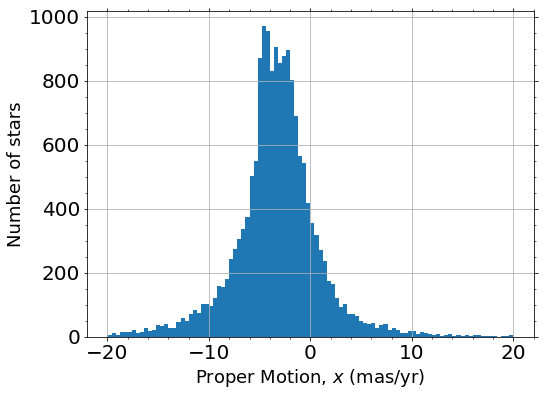

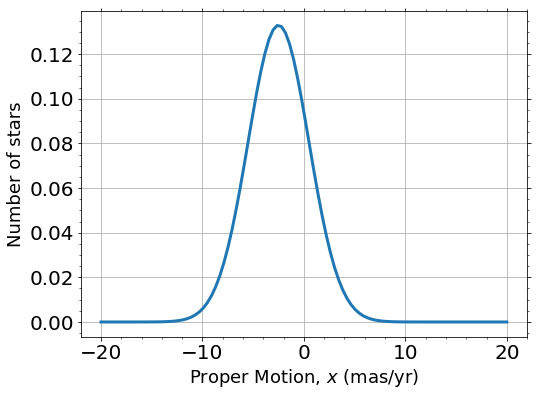

In [7]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.hist(t['pmra'], bins=100, range=(-20, 20))
ax.set_xlabel(r"Proper Motion, $x$ (mas/yr)")
ax.set_ylabel('Number of stars')
plt.show()

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.set_xlabel(r"Proper Motion, $x$ (mas/yr)")
ax.set_ylabel('Number of stars')
x = np.linspace(-20, 20, 100)
plt.plot(x, gaussian_dist(x, -2.5, 3))
plt.show()

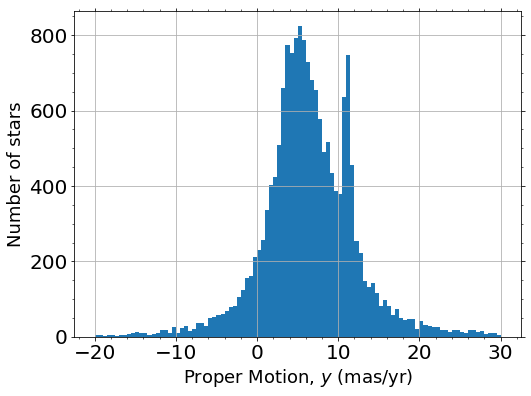

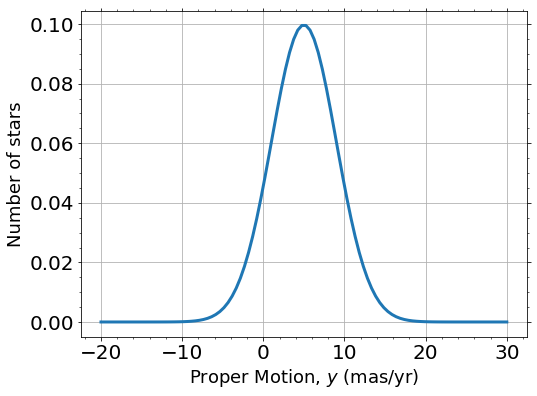

In [8]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.hist(t['pmdec'], bins=100, range=(-20, 30))
ax.set_xlabel(r"Proper Motion, $y$ (mas/yr)")
ax.set_ylabel('Number of stars')
plt.show()

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.set_xlabel(r"Proper Motion, $y$ (mas/yr)")
ax.set_ylabel('Number of stars')
x = np.linspace(-20, 30, 100)
plt.plot(x, gaussian_dist(x, 5, 4))
plt.show()

Using the fit function in the question, we fit for 5 parameters with 6 sets of data inputted. Fitting for $\mu_{x, cl}$, $\mu_{y, cl}$, $\omega_{cl}$ (the cluster’s proper motion and parallax) and $\sigma_{x, cl}^2$, $\sigma_{y, cl}^2$ (measures of the internal velocity dispersion, and indirectly, of the cluster’s mass). The inputted datas are $\mu_{x, i}$, $\mu_{y, i}$, $\omega_{i}$ (proper motion in x, y, and parallax) and $\sigma_{x, i}^2$, $\sigma_{y, i}^2$, $\sigma_{\omega, i}^2$ (errors on these values) all given in the original dataset.

The priors for the mixture model are the same as before and the means of the 'bad' distribution are done in the same way as before by estimating from the plots above.

In [36]:
def gaussian_dist_3d(datas, means, errs):

    A = 1 / ( np.power(2*np.pi, 3/2) * np.sqrt(errs[0]**2 * errs[1]**2 * errs[2]**2) )
    exponent = (datas[0] - means[0])**2/(errs[0]**2) + (datas[1] - means[1])**2/(errs[1]**2) + (datas[2] - means[2])**2/(errs[2]**2)

    return A * np.exp(-0.5*exponent)

def likelihood_3d(params, datas, errors):

    p_good = gaussian_dist_3d(datas, [params[0], params[1], params[2]], [np.sqrt(params[3]**2 + errors[0]**2),
                                                                         np.sqrt(params[4]**2 + errors[1]**2), errors[2]])
    p_bad = gaussian_dist_3d(datas, [-2.5, 5, 0.6], [10*np.sqrt(params[3]**2 + errors[0]**2), 10*np.sqrt(params[4]**2 + errors[1]**2),
                                                     10*errors[2]])

    return p_prior_good * p_good + p_prior_bad * p_bad

def neg_tot_likelihood_3d(params, datas, errors):

    return - np.sum(np.log(likelihood_3d(params, datas, errors)))

best_params = scipy.optimize.minimize(neg_tot_likelihood_3d, np.array([-5, 10, 2.5, 0.5, 0.5]),
                               args=([t['pmra'], t['pmdec'], parallax_data], [t['pmra_error'], t['pmdec_error'], parallax_data_errs])).x

print(f"Best fit proper motions in x, y and parallax: {best_params[0]:.3f} mas/yr, {best_params[1]:.2f} mas/yr, "
      f"{best_params[2]:.3f} milliarcseconds")
print(f"Best fit sigmas (internal velocity dispersions): {best_params[3]:.4f} mas/yr, {best_params[4]:.4f} mas/yr")


Best fit proper motions in x, y and parallax: -4.689 mas/yr, 11.17 mas/yr, 2.413 milliarcseconds
Best fit sigmas (internal velocity dispersions): 0.5530 mas/yr, 0.7235 mas/yr


Again we can use bootstrap resampling to get an estimate of the erros on these parameters since this is a much better estimate than assuming the likelihood to be gaussian (as we saw before).

In [10]:
%%time

samples_best_params = np.empty((0, 5))
no_samples = 100
for i in range(no_samples):
    samples_index = np.random.randint(0, len(parallax_data), size=len(parallax_data))

    parallax_data_sample = parallax_data[samples_index]
    parallax_data_errs_sample = parallax_data_errs[samples_index]
    prop_motion_x_sample = t['pmra'][samples_index]
    prop_motion_x_errs_sample = t['pmra_error'][samples_index]
    prop_motion_y_sample = t['pmdec'][samples_index]
    prop_motion_y_errs_sample = t['pmdec_error'][samples_index]

    sample_best_params = scipy.optimize.minimize(neg_tot_likelihood_3d, np.array([-5, 10, 2.5, 0.5, 0.5]),
                                                 args=([prop_motion_x_sample, prop_motion_y_sample, parallax_data_sample],
                                                      [prop_motion_x_errs_sample, prop_motion_y_errs_sample, parallax_data_errs_sample])).x
    samples_best_params = np.vstack((samples_best_params, sample_best_params))

best_params_errs = np.std(samples_best_params, axis=0)
print(f"Error on proper motions in x, y and parallax: {best_params_errs[0]:.4f} mas/yr, {best_params_errs[1]:.4f} mas/yr, "
      f"{best_params_errs[2]:.5f} milliarcseconds")
print(f"Error on sigmas (internal velocity dispersions): {best_params_errs[3]:.4f} mas/yr, {best_params_errs[4]:.4f} mas/yr")
print(f"(confidence in these values is roughly {1/np.sqrt(no_samples) * 100:.2f} %)")
print()

C:\Users\divij\AppData\Local\Temp\ipykernel_13656\2287944674.py:19: RuntimeWarning: divide by zero encountered in log
  return - np.sum(np.log(likelihood_3d(params, datas, errors)))
C:\Users\divij\anaconda3\envs\phys20161\lib\site-packages\scipy\optimize\_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\divij\AppData\Local\Temp\ipykernel_13656\2287944674.py:19: RuntimeWarning: divide by zero encountered in log
  return - np.sum(np.log(likelihood_3d(params, datas, errors)))
C:\Users\divij\AppData\Local\Temp\ipykernel_13656\2287944674.py:19: RuntimeWarning: divide by zero encountered in log
  return - np.sum(np.log(likelihood_3d(params, datas, errors)))
C:\Users\divij\anaconda3\envs\phys20161\lib\site-packages\scipy\optimize\_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\divij\AppData\Local\Temp\ipykernel_13656\2287944674.py:19: RuntimeWarning: divide by zero encountered in log
  return -

Error on proper motions in x, y and parallax: 0.0223 mas/yr, 0.0175 mas/yr, 0.00199 milliarcseconds
Error on sigmas (internal velocity dispersions): 0.0162 mas/yr, 0.0116 mas/yr
(confidence in these values is roughly 10.00 %)

CPU times: total: 35.1 s
Wall time: 35.2 s


### d.)

We can write the posterior probability as:

$$ P_{post}(good) = \left( 1 + \frac{P_{prior}(bad) P_{bad}}{P_{prior}(good) P_{good}} \right)^{-1} $$

and plot this over the original image plot instead of the parallax to see which stars are members of the cluster visually.

C:\Users\divij\AppData\Local\Temp\ipykernel_13656\858063035.py:8: RuntimeWarning: divide by zero encountered in true_divide
  return np.power(1 + (p_prior_bad * p_bad)/(p_prior_good * p_good), -1)
C:\Users\divij\AppData\Local\Temp\ipykernel_13656\858063035.py:8: RuntimeWarning: overflow encountered in true_divide
  return np.power(1 + (p_prior_bad * p_bad)/(p_prior_good * p_good), -1)


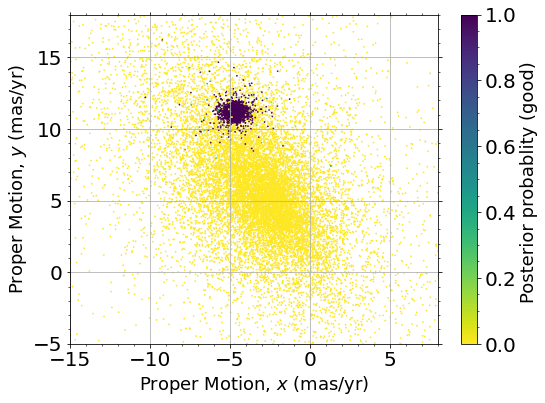

In [11]:
def posterior_good_3d(params, datas, errors):

    p_good = gaussian_dist_3d(datas, [params[0], params[1], params[2]], [np.sqrt(params[3]**2 + errors[0]**2),
                                                                         np.sqrt(params[4]**2 + errors[1]**2), errors[2]])
    p_bad = gaussian_dist_3d(datas, [-2.5, 5, 0.6], [10*np.sqrt(params[3]**2 + errors[0]**2), 10*np.sqrt(params[4]**2 + errors[1]**2),
                                                     10*errors[2]])

    return np.power(1 + (p_prior_bad * p_bad)/(p_prior_good * p_good), -1)

post_good = posterior_good_3d(best_params, [t['pmra'], t['pmdec'], parallax_data], [t['pmra_error'], t['pmdec_error'], parallax_data_errs])

plt.figure(figsize=(8, 6))
plt.scatter(t['pmra'], t['pmdec'], c=post_good, s=0.5, cmap="viridis_r")
plt.xlim(-15, 8)
plt.ylim(-5, 18)
plt.colorbar(label="Posterior probablity (good) ")
plt.xlabel(r"Proper Motion, $x$ (mas/yr)")
plt.ylabel(r"Proper Motion, $y$ (mas/yr)")
plt.tight_layout()
plt.show()

## Part 2 : MCMC

We use MCMC to derive parameters and confidence intervals from problem 2 in homework 2.

Start with making our own Metropolis Hastings algorithm. For now work with the model from Part 2a but with the exponent free:

$$ T[\nu] \approx a_0 \nu^{-2.5} + a_1 \nu^{-2.5} ln{\nu} + a_2 \nu^{-2.5} (ln{\nu})^2 + a_3 \nu^{-4.5} + a_4 \nu_{1}^{-2} + c_0 \cdot exp \left[ - \left| \frac{\nu - c_1}{c_2} \right|^{\sqrt{c_3^2}} \right] $$

and with a diagonal covariance matrix with entries $\sigma_T = 25 mK$ (uncorrelated) so that : $ \Sigma_{ij} = \delta_{ij} \sigma_T^2 $. This means, since the residuals are gaussian like, we can write the likelihood as:

$$ L = \frac{1}{\sqrt{(2\pi)^N det(\Sigma)}} exp \left[ -\frac{1}{2} (d - T)^T \Sigma^{-1} (d - T) \right] = \frac{1}{\sqrt{(2\pi \sigma_T^2)^N }} exp \left[ -\frac{1}{2} \frac{1}{\sigma_T^2} \sum_{i=1}^N (d_i - T_i)^2 \right] $$

where $d$ is the sky temperature data and $N$ is the number of datapoints.

Can ignore leading constant in likelihood as it will cancel in division

In [12]:
central_freq = 75

all_data = np.genfromtxt('skytemperature.csv', delimiter=',', skip_header=1)
all_data = all_data[3:-2]   # Removing points with zero weight and no data

frequencies = all_data[:, 0]    # MHz
frequencies_frac = frequencies / central_freq   # No units
sky_temps = all_data[:, 2]  # K

cov_power = np.diag(np.ones(len(sky_temps)) * 1/0.025)
d = sky_temps

def sampling_log_likelihood(nl_params):

    A = np.empty((0, 6))
    for freq in frequencies_frac:
        temp = np.array([ freq**(-2.5), freq**(-2.5)*np.log(freq), freq**(-2.5)*(np.log(freq))**2, freq**(-4.5), freq**(-2),
                          np.exp(-np.power(np.abs((freq - nl_params[0])/nl_params[1]), np.sqrt(nl_params[2]**2))) ])
        A = np.vstack((A, temp))

    theta_MLE = np.linalg.lstsq(np.dot(cov_power, A), np.dot(cov_power, d), rcond=None)[0]
    theta_MLE_cov = np.linalg.pinv(np.dot(A.T, np.dot(cov_power**2, A)))
    
    T = np.dot(A, theta_MLE)

    return np.log(np.sqrt(np.linalg.det(theta_MLE_cov))) + (-0.5 * np.dot((d - T).T, np.dot(cov_power**2, (d - T))))

In [13]:
no_walkers = 10
n_dim = 3

def run_MCMC(no_steps, sigmas_guess):
    guesses = np.empty((0, n_dim))
    sigmas = np.empty((0, n_dim))
    for _ in range(no_walkers):
        temp_guess = [1.04, 0.2, 5]                      # Using 78/75, 15/75 and 5 guesses from question in hmw 2
        guesses = np.vstack((guesses, temp_guess))
        temp_sigma = sigmas_guess
        sigmas = np.vstack((sigmas, temp_sigma))

    samples = np.empty((no_walkers, n_dim, 0))
    samples = np.dstack((samples, guesses))
    acceptances = np.empty((no_walkers, n_dim, 0))
    x = guesses

    for i in range(no_steps):

        par_to_vary = np.random.randint(n_dim, size=no_walkers)
        dx = np.zeros((no_walkers, n_dim))
        dx[np.arange(len(dx)), par_to_vary] = np.random.normal(size=no_walkers) * sigmas[np.arange(len(sigmas)), par_to_vary]

        p_accept = np.array([])
        for j in range(no_walkers):
            temp = np.exp(sampling_log_likelihood(x[j] + dx[j]) - sampling_log_likelihood(x[j]))
            p_accept = np.append(p_accept, temp)
        reject = np.random.rand(no_walkers) > p_accept

        dx[reject] = 0
        x += dx
        samples = np.dstack((samples, x))

        acceptance = np.zeros((no_walkers, n_dim))
        acceptance[np.arange(len(acceptance)), par_to_vary] = np.where(reject, 1, 2)
        acceptances = np.dstack((acceptances, acceptance))

    # Acceptance : 0 = not chosen, 1 = chosen rejected, 2 = chosen accepted
    # Dimensionality for samples is : walkers, params, steps

    return samples, acceptances

In [14]:
def find_acceptance_rate(acceptances):

    acceptance_rates = np.array([])
    for i in range(n_dim):
        acceptance_list = acceptances[:, i].flatten()
        no_accepted = len(np.where(acceptance_list == 2)[0])
        no_rejected = len(np.where(acceptance_list == 1)[0])
        acceptance_rate = no_accepted / (no_accepted + no_rejected)
        acceptance_rates = np.append(acceptance_rates, acceptance_rate)

    return acceptance_rates

In [34]:
%%time

sigma_trial = np.array([0.2, 0.2, 0.5])
sigma_change = np.array([0.01, 0.01, 0.1])
while True:

    samples_full, acc = run_MCMC(300, sigma_trial)
    acc_rates = find_acceptance_rate(acc)

    ind_to_inc = np.where(acc_rates > 0.35)[0]
    ind_to_dec = np.where(acc_rates < 0.15)[0]

    print(sigma_trial)
    print(acc_rates)
    print()

    if len(ind_to_dec) + len(ind_to_inc) == 0:
        break

    sigma_trial[ind_to_inc] += sigma_change[ind_to_inc]
    sigma_trial[ind_to_dec] -= sigma_change[ind_to_dec]


C:\Users\divij\AppData\Local\Temp\ipykernel_13656\2985396252.py:26: RuntimeWarning: invalid value encountered in sqrt
  return np.log(np.sqrt(np.linalg.det(theta_MLE_cov))) + (-0.5 * np.dot((d - T).T, np.dot(cov_power**2, (d - T))))
C:\Users\divij\AppData\Local\Temp\ipykernel_13656\2985396252.py:26: RuntimeWarning: divide by zero encountered in log
  return np.log(np.sqrt(np.linalg.det(theta_MLE_cov))) + (-0.5 * np.dot((d - T).T, np.dot(cov_power**2, (d - T))))
C:\Users\divij\AppData\Local\Temp\ipykernel_13656\2779994840.py:26: RuntimeWarning: invalid value encountered in double_scalars
  temp = np.exp(sampling_log_likelihood(x[j] + dx[j]) - sampling_log_likelihood(x[j]))


[0.2 0.2 0.5]
[0.05833764 0.07537206 0.33080808]



C:\Users\divij\AppData\Local\Temp\ipykernel_13656\2779994840.py:26: RuntimeWarning: overflow encountered in exp
  temp = np.exp(sampling_log_likelihood(x[j] + dx[j]) - sampling_log_likelihood(x[j]))


[0.19 0.19 0.5 ]
[0.093702   0.11226508 0.36493827]

[0.18 0.18 0.6 ]
[0.04095046 0.08416834 0.30898322]

[0.17 0.17 0.6 ]
[0.03924491 0.07707809 0.24225774]

[0.16 0.16 0.6 ]
[0.04097117 0.09535696 0.32524752]

[0.15 0.15 0.6 ]
[0.07742915 0.0952381  0.27539841]

[0.14 0.14 0.6 ]
[0.03875189 0.0969697  0.30988687]

[0.13 0.13 0.6 ]
[0.04536391 0.07848982 0.34528016]

[0.12 0.12 0.6 ]
[0.05231984 0.07209877 0.36172396]

[0.11 0.11 0.7 ]
[0.0367388  0.0628091  0.37117027]

[0.1 0.1 0.8]
[0.04301075 0.07501267 0.29934377]

[0.09 0.09 0.8 ]
[0.03525323 0.0672016  0.32580321]

[0.08 0.08 0.8 ]
[0.05409664 0.09063745 0.28783525]

[0.07 0.07 0.8 ]
[0.04460213 0.07696127 0.3750621 ]

[0.06 0.06 0.9 ]
[0.06680265 0.07879656 0.32390746]

[0.05 0.05 0.9 ]
[0.06487026 0.10025063 0.27286357]

[0.04 0.04 0.9 ]
[0.07088608 0.09934772 0.34301181]

[0.03 0.03 0.9 ]
[0.06830738 0.09778226 0.36098765]

[0.02 0.02 1.  ]
[0.10394089 0.14616142 0.33333333]

[0.01 0.01 1.  ]
[0.17213115 0.24900794 0.3996063

In [26]:
no_walkers = 10
sigma_best = sigma_trial
samples_full, acc = run_MCMC(500, sigma_best)

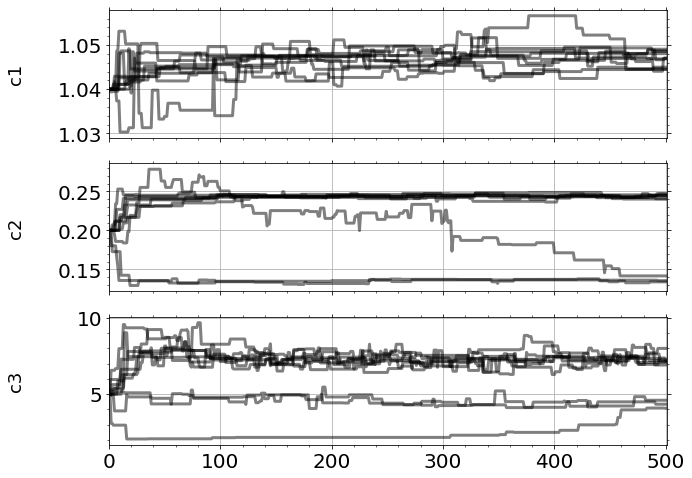

In [27]:
fig, axes = plt.subplots(n_dim, figsize=(10, 8), sharex=True)
param_names = ['c1', 'c2', 'c3']
for i in range(n_dim):
    ax = axes[i]
    for j in range(no_walkers):
        ax.plot(samples_full[j, i], color='k', alpha=0.5)
    ax.set_xlim(0, len(samples_full[0, 0]))
    ax.set_ylabel(param_names[i])
    ax.yaxis.set_label_coords(-0.15, 0.5)
plt.show()

Feels like something is wrong and the chain isn't converging to the right parameters but not sure why. Maybe being generous we can discard the first 100 ish points.

Not sure why some of the walkers dont have any variation?

In [28]:
burn_in = 100
samples_full = samples_full[:, :, burn_in:]

samples_flat = np.empty((0, len(samples_full[0, 0])*no_walkers))
for i in range(n_dim):
    temp = samples_full[:, i].flatten()
    samples_flat = np.vstack((samples_flat, temp))
samples_flat = samples_flat.T

In [29]:
def correlation_length(n, sample):

    n = int(n)
    total_var = np.var(sample)
    subchains = np.split(sample, np.arange(n, len(sample), n))[:-1]
    subchains_var = np.var(subchains, axis=1)
    subchains_var_avg = np.mean(subchains_var)

    return np.abs(0.5 * total_var - subchains_var_avg)

def minimise_corr_length(sample):

    n_trials = np.linspace(1, 1000, 1000)
    outputs = []
    for trial in n_trials:
        outputs.append(correlation_length(trial, sample))
    min_index = np.argmin(outputs)
    n_best = n_trials[min_index]

    return n_best

In [30]:
corr_lengths = []
for i in range(n_dim):
    corr_lengths.append(minimise_corr_length(samples_flat[:, i]))
print(corr_lengths)
corr_length = max(corr_lengths)

[162.0, 867.0, 615.0]


We take the largest as the autocorrection length. This feels very big but Im not sure why.

Finally, we can now generate our 100,000 points, discard burn in, correct for correlation and plot the corner plots

In [31]:
%%time

no_walkers = 20
samples_full, acc = run_MCMC(5000, sigma_best)

CPU times: total: 1h 2min 21s
Wall time: 10min 31s


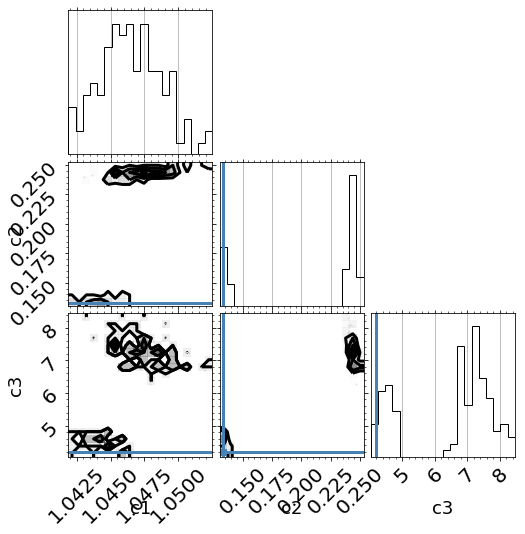

In [32]:
samples_full = samples_full[:, :, burn_in:]       # Removing burn-in

samples_flat = np.empty((0, len(samples_full[0, 0])*no_walkers))
for i in range(n_dim):
    temp = samples_full[:, i].flatten()
    samples_flat = np.vstack((samples_flat, temp))
samples_flat = samples_flat.T

samples_flat = samples_flat[::int(corr_length)]      # Removing correlation effects

fig = corner.corner(samples_flat, labels=param_names, figsize=(20, 20), truths=[1.04, 0.133, 4.2])

These distributions seem to be working well but part of this is probably due to some of the walkers not doing anything and staying near their starting values which were by design close to the true values.

Now looking at the full non-linear model from last homework given in the question, we vary 8 parameters (but fixing power of 2.8) with the full covariance matrix from last homework (question 2, part 3, part a). We then use the 'emcee' package to create our markov chain, discard burn in, find correlation length and make corner plots with 'corner' package.

In [ ]:
A = 0.025**2
B = 2 * A

cov_full = np.empty((0, len(frequencies)))
for freq1 in frequencies:
    temp = np.array([])
    for freq2 in frequencies:
        to_append = B * np.cos(0.3 * (freq1 - freq2)) * np.exp(-np.abs((freq1 - freq2)/60))
        if freq1 == freq2:
            to_append += A
        temp = np.append(temp, to_append)
    cov_full = np.vstack((cov_full, temp))

def true_sampling_log_likelihood(params):

    term1 = -2.5 + params[1] + params[2]*np.log(frequencies_frac)
    term2 = -params[3] * frequencies_frac**(-2)
    T = params[0] * np.power(frequencies_frac, term1) * np.exp(term2) + params[4]*frequencies_frac**(-2) + \
        params[5] * np.exp(-np.power(np.abs((frequencies_frac - params[6])/params[7]), 2.8))

    return -0.5 * np.dot((d - T).T, np.dot(cov_full, (d - T)))

Using 300 samples initially to visually get a sense of the burn in length. The parameter guesses are from the previous homework (remember c1 and c2 are freq fractions, divided by 75 MHz, to be dimensionless) so that the program runs somewhat smoothly.

Each walker is given a slightly different choice of initial parameters by adding some noise. This and the 20 walkers are based on the documentation suggestions.

In [ ]:
no_walkers = 20
n_dim = 8
guesses = np.empty((0, n_dim))
for _ in range(no_walkers):
    temp = [700, -0.4, -0.7, -0.1, 900, -0.5, 1, 0.15]
    for index, val in enumerate(temp):
        noise = val / 100
        temp[index] = np.random.uniform(val - noise, val + noise)
    guesses = np.vstack((guesses, temp))

sampler = emcee.EnsembleSampler(no_walkers, n_dim, true_sampling_log_likelihood)

state = sampler.run_mcmc(guesses, 300)

In [ ]:
fig, axes = plt.subplots(n_dim, figsize=(10, 24), sharex=True)
samples_full = sampler.get_chain()
param_names = ['b0', 'b1', 'b2', 'b3', 'b4', 'c0', 'c1', 'c2']
for i in range(n_dim):
    ax = axes[i]
    ax.plot(samples_full[:, :, i], color='k', alpha=0.5)
    ax.set_xlim(0, len(samples_full))
    ax.set_ylabel(param_names[i])
    ax.yaxis.set_label_coords(-0.15, 0.5)
plt.show()

Looks like after a couple of hundred steps it is sampling from the distribution. We can take 250 steps as our burn-in as a conservative estimate so we will discard these.

Plotting one histogram visually see if the sampling is working

In [ ]:
samples_flat = sampler.get_chain(flat=True)
plt.figure(figsize=(8, 8))
for i in range(no_walkers):
    plt.hist(samples_flat[:, 0], 100)
plt.title('b0')
plt.show()

Histogram looks ok.

We can now compute the full 100,000 steps after resetting the sampler

In [ ]:
%%time
sampler.reset()
state = sampler.run_mcmc(guesses, 100_000)

Using the inbuilt function to find the correlation length

In [ ]:
corr_len = sampler.get_autocorr_time()
print(corr_len)

Not sure what the problem is here, I will just estimate the correlation length to be of a similar order to the burn in length as 100.

Using this burn in and correlation length, we can extract the relevant values from our chain and make corner plots. The blue 'truth' values are estimated based on curve-fit to get a crude estimate of the values that we should be getting, this is without using the covariance matrix through so should only be used as a rough estimate.

In [ ]:
def physical_model(freq_fracs, b0, b1, b2, b3, b4, c0, c1, c2):

    term1 = -2.5 + b1 + b2*np.log(freq_fracs)
    term2 = -b3 * freq_fracs**(-2)
    term3 = c0 * np.exp(-np.power(np.abs((freq_fracs - c1)/c2), 2.8))

    return b0 * np.power(freq_fracs, term1) * np.exp(term2) + b4*freq_fracs**(-2) + term3

theta_MLE, theta_MLE_cov = scipy.optimize.curve_fit(physical_model, frequencies_frac, sky_temps, p0=temp)
print(theta_MLE)

In [ ]:
burn_in = 250
corr_len = 100

samples_flat = sampler.get_chain(discard=burn_in, thin=corr_len, flat=True)
fig = corner.corner(samples_flat, labels=param_names, figsize=(20, 20), truths=theta_MLE)

# [740, -0.44, -0.69, -0.12, 911, -0.56, 1.04, 0.13]

These look somewhat odd with not very well-defined peaks looking like a multimodal distribution (as is suggested in the question because of the value of the exponent).

'Emcee' seems to have done reasonably well in finding the best fit parameters that agree with curve fit although the values for b0 and b4 in particular differ a lot.

If we know the distribution to be multimodal, the correlation length should be much higher ? (not sure)

## Part 3 : PCA

First is to calculate the mean image and subtract it from all the images to get the residual image that is used as a template to approximate. The we find the SVD of the residual and plot the mean image and first 2 principal components using our $V$ matrix.

In [ ]:
images = fits.open("image_cropped.fits")[0].data

mean_image = np.mean(images, axis=0)
residuals = images - mean_image
residuals = np.reshape(residuals, (images.shape[0], -1))
U, W, V_T = np.linalg.svd(residuals, full_matrices=False)
bases = np.reshape(V_T, images.shape)

# Remember W is conventionally largest to the smallest singular value
# -1 apparently does the shape calculation for you

In [ ]:
def plot_image(image, title):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.imshow(image)
    ax.set_title(title, fontsize=15, y=1.02)
    plt.xticks(fontsize=15, fontname='Times new Roman')
    plt.yticks(fontsize=15, fontname='Times new Roman')
    plt.show()

In [ ]:
plot_image(mean_image, 'Mean image')
plot_image(bases[0], '1st principal component')
plot_image(bases[1], '2nd principal component')
plot_image(bases[25], '26th principal component')
plot_image(bases[35], '36th principal component')

We also plot the fractional residual variance as a function of the number of principal components in W to see where we can truncate our decomposition

In [ ]:
variance_frac = np.cumsum(W**2)/np.sum(W**2)
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
plt.scatter(range(len(W)), variance_frac)
ax.set_xlabel('Number of principle components', fontsize=18, fontname='Times new Roman')
ax.set_ylabel('Fractional residual variance', fontsize=18, fontname='Times new Roman')
plt.xticks(fontsize=15, fontname='Times new Roman')
plt.yticks(fontsize=15, fontname='Times new Roman')
plt.show()

Looks like with the first 9 components we can capture 95% of the variance of the image after which point we start to get diminishing returns.

Now adding some noise to the images and doing the same plotting. In particular, we look at less significant principle components now to see how they differ.

In [ ]:
badpix = (np.random.uniform(0, 1, images.shape) > 0.9999)*(images != 0)
badpixval = np.std(images)*100
images += badpix*np.random.uniform(0, badpixval, images.shape)

In [ ]:
mean_image = np.mean(images, axis=0)
residuals = images - mean_image
residuals = np.reshape(residuals, (images.shape[0], -1))
U, W, V_T = np.linalg.svd(residuals, full_matrices=False)
bases = np.reshape(V_T, images.shape)

In [ ]:
plot_image(mean_image, 'Mean image')
plot_image(bases[0], '1st principal component')
plot_image(bases[1], '2nd principal component')
plot_image(bases[25], '26th principal component')
plot_image(bases[35], '36th principal component')

From this it is evident that the SVD is not good at dealing with noisy data and even the second principal component has already lost its shape. However, the latter principal components seem to show the structure of the image a bit better than the same ones before the noise was added which is particularly evident in the 36th one plotted above.

To see why the SVD is not good for noisy data, we can look at figure 1 in lecture 15. For noisy data, there will be a lot more 'outliers' and so when we take the SVD, or in this picture find the "optimal x'", it will be heavily dominated by the outliers as they will have a much larger perpendicular length of projection on x'.

The reason why the structure is better for higher principal components is  ?